In [1]:
import pandas as pd
import numpy as np
import nltk
import pickle
from collections import Counter
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import AFLCIO Dataset

df = pd.read_csv('ALFCIO Speeches.csv')

In [3]:
df

,Unnamed: 0,Speech Title,Url Link,Date,Speech Text,Speaker
0,0,Shuler: We Can Make Dr. King's Dream a Reality,https://aflcio.org/speeches/shuler-we-can-make...,1-13-2023,AFL-CIO President Liz Shuler delivered the fol...,Shuler
1,1,Redmond: We Must Be That Mighty Force for Change,https://aflcio.org/speeches/redmond-we-must-be...,1-13-2023,AFL-CIO Secretary-Treasurer Fred Redmond deliv...,Redmond
2,2,Redmond: Technological Achievement Should Not ...,https://aflcio.org/speeches/redmond-technologi...,1-6-2023,AFL-CIO Secretary-Treasurer Fred Redmond's rem...,Redmond
3,3,Shuler: Innovation Should Empower Workers and ...,https://aflcio.org/speeches/shuler-innovation-...,1-6-2023,AFL-CIO President Liz Shuler's remarks as prep...,Shuler
4,4,Redmond: We Need the Missouri Labor Movement N...,https://aflcio.org/speeches/redmond-we-need-mi...,8-22-2022,Secretary-Treasurer Fred Redmond delivered the...,Redmond
...,...,...,...,...,...,...
404,404,Shuler 2013 AFL-CIO Convention Acceptance,https://aflcio.org/speeches/shuler-2013-afl-ci...,9-10-2013,Wow! Thank you. Thank you all so much.Brother...,Shuler
405,405,Gebre 2013 AFL-CIO Convention Acceptance,https://aflcio.org/speeches/gebre-2013-afl-cio...,9-10-2013,"Thank you, brothers and sisters, for your conf...",Gebre
406,406,Trumka 2013 AFL-CIO Convention Keynote,https://aflcio.org/speeches/trumka-2013-afl-ci...,9-9-2013,Thank you. Thank you for being here. Together...,Trumka
407,407,Remarks of AFL-CIO President Richard L. Trumka...,https://aflcio.org/speeches/remarks-afl-cio-pr...,9-6-2013,Thank you for all for coming together here in ...,Trumka


In [4]:
#often, we want to remove stopwords
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 
                     'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 
                     'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 
                     'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 
                     'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 
                     'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 
                     'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 
                     'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 
                     'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 
                     'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 
                     'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 'can', 'will',
                     'just', 'dont', 'should', 'aint', 'arent', 'couldn', 'could', 'would', 'much', 'must',
                     'didnt', 'doesnt', 'hadnt', 'hasnt', 'havent', 'isnt', 'mightnt', 'mustnt', 'neednt', 'shan',
                     'shouldnt', 'wasnt', 'werent', 'wont', 'wouldnt','rt','mt','amp','mil','ve','don','s','st','pres','req','aft','ua']

In [5]:
 #adopted from catriscode, https://catriscode.com/2021/05/01/tweets-cleaning-with-python/

import numpy as np
import re

def clean_speech(speech):
    """cleans the speech"""
    raw_speech = str(speech)
    if type(speech) == float:
        return ""
    temp = re.sub("'", "", str(speech)) # to avoid removing contractions in english
    temp = temp.lower()
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub(r"www.\S+", "", temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    #temp = re.sub("[^a-z0-9]"," ", temp) # this removes all letters including CO2
    temp = re.sub("[^a-z]"," ", temp)
    temp = temp.split()
    temp = [w for w in temp if not w in stopwords]
    temp = " ".join(word for word in temp)
    
    if temp is None:
        print (raw_speech,temp)
        
    return temp

# create a clean text column
df['clean_text'] = df['Speech Text'].apply(clean_speech)

In [6]:
# remove the speakers and the orginization afl due to it being mentioned 
# in the beginning of every speech

# define a lowercased speaker list and include afl
speakers = list(df['Speaker'].unique())
speakers = [i.lower() for i in speakers]
# add specific words 

words_to_remove = ['cio', 'president', 'thank', 'secretary', 'treasurer', 'afl', 'cio',
                  'us', "'re"]

for word in words_to_remove:
    speakers.append(word)
    
print(speakers)

def remove_afl(speech):

    for word in speakers:
        
        temp = re.sub(word, '', speech)
    return temp

['shuler', 'redmond', 'afl', 'gebre', 'trumka', 'cio', 'president', 'thank', 'secretary', 'treasurer', 'afl', 'cio', 'us', "'re"]


In [7]:
df['processed_clean'] = df['clean_text'].apply(remove_afl)

In [8]:
df['processed_clean_list'] = [l.split() for l in df['processed_clean']]

In [9]:
df['processed_clean_list'][10]

['president',
 'liz',
 'shuler',
 'delivered',
 'following',
 'remarks',
 'prepared',
 'ibews',
 'th',
 'convention',
 'chicago',
 'good',
 'morning',
 'everyone',
 'thank',
 'president',
 'stephenson',
 'kind',
 'introduction',
 'secretary',
 'treasurer',
 'cooper',
 'incredible',
 'job',
 'leading',
 'ibew',
 'm',
 'grateful',
 'everything',
 'afl',
 'cio',
 'congratulations',
 're',
 'election',
 'm',
 'proud',
 'ibew',
 'member',
 'watch',
 'union',
 'reach',
 'new',
 'heights',
 'leadership',
 'congratulations',
 'international',
 'vice',
 'presidents',
 'international',
 'executive',
 'councii',
 'members',
 'elections',
 'll',
 'give',
 'special',
 'shout',
 'th',
 'district',
 'vp',
 'paul',
 'noble',
 'started',
 'weeks',
 'ago',
 'already',
 'national',
 'convention',
 'backyard',
 'well',
 'done',
 'paul',
 'absolute',
 'honor',
 'ibew',
 'convention',
 'm',
 'home',
 'heard',
 'grew',
 'electric',
 'utility',
 'industry',
 'generations',
 'worked',
 'company',
 'back',
 'li

In [10]:
df.to_csv('AFL Cleaned Text.csv')

In [11]:
df

,Unnamed: 0,Speech Title,Url Link,Date,Speech Text,Speaker,clean_text,processed_clean,processed_clean_list
0,0,Shuler: We Can Make Dr. King's Dream a Reality,https://aflcio.org/speeches/shuler-we-can-make...,1-13-2023,AFL-CIO President Liz Shuler delivered the fol...,Shuler,afl cio president liz shuler delivered followi...,afl cio president liz shuler delivered followi...,"[afl, cio, president, liz, shuler, delivered, ..."
1,1,Redmond: We Must Be That Mighty Force for Change,https://aflcio.org/speeches/redmond-we-must-be...,1-13-2023,AFL-CIO Secretary-Treasurer Fred Redmond deliv...,Redmond,afl cio secretary treasurer fred redmond deliv...,afl cio secretary treasurer fred redmond deliv...,"[afl, cio, secretary, treasurer, fred, redmond..."
2,2,Redmond: Technological Achievement Should Not ...,https://aflcio.org/speeches/redmond-technologi...,1-6-2023,AFL-CIO Secretary-Treasurer Fred Redmond's rem...,Redmond,afl cio secretary treasurer fred redmonds rema...,afl cio secretary treasurer fred redmonds rema...,"[afl, cio, secretary, treasurer, fred, redmond..."
3,3,Shuler: Innovation Should Empower Workers and ...,https://aflcio.org/speeches/shuler-innovation-...,1-6-2023,AFL-CIO President Liz Shuler's remarks as prep...,Shuler,afl cio president liz shulers remarks prepared...,afl cio president liz shulers remarks prepared...,"[afl, cio, president, liz, shulers, remarks, p..."
4,4,Redmond: We Need the Missouri Labor Movement N...,https://aflcio.org/speeches/redmond-we-need-mi...,8-22-2022,Secretary-Treasurer Fred Redmond delivered the...,Redmond,secretary treasurer fred redmond delivered fol...,secretary treasurer fred redmond delivered fol...,"[secretary, treasurer, fred, redmond, delivere..."
...,...,...,...,...,...,...,...,...,...
404,404,Shuler 2013 AFL-CIO Convention Acceptance,https://aflcio.org/speeches/shuler-2013-afl-ci...,9-10-2013,Wow! Thank you. Thank you all so much.Brother...,Shuler,wow thank thank brothers sisters true joy stan...,wow thank thank brothers sisters true joy stan...,"[wow, thank, thank, brothers, sisters, true, j..."
405,405,Gebre 2013 AFL-CIO Convention Acceptance,https://aflcio.org/speeches/gebre-2013-afl-cio...,9-10-2013,"Thank you, brothers and sisters, for your conf...",Gebre,thank brothers sisters confidence want thank j...,thank brothers sisters confidence want thank j...,"[thank, brothers, sisters, confidence, want, t..."
406,406,Trumka 2013 AFL-CIO Convention Keynote,https://aflcio.org/speeches/trumka-2013-afl-ci...,9-9-2013,Thank you. Thank you for being here. Together...,Trumka,thank thank together solidarity look around gr...,thank thank together solidarity look around gr...,"[thank, thank, together, solidarity, look, aro..."
407,407,Remarks of AFL-CIO President Richard L. Trumka...,https://aflcio.org/speeches/remarks-afl-cio-pr...,9-6-2013,Thank you for all for coming together here in ...,Trumka,thank coming together los angeles thank kind i...,thank coming together los angeles thank kind i...,"[thank, coming, together, los, angeles, thank,..."


In [12]:
# creating a wordcloud of the most common words
words = df['processed_clean_list']
allwords = []
for wordlist in words:
    allwords += wordlist

In [13]:

# Remove elements that only contain "re", "ll", "u", "m"
allwords = [s for s in allwords if len(s) > 2 or s != 're']

allwords = [s for s in allwords if len(s) > 2 or s != 'll']

allwords = [s for s in allwords if len(s) > 1 or s != 'u']

allwords = [s for s in allwords if len(s) > 1 or s != 'm']

from collections import Counter

Counter(allwords).most_common(25)

[('people', 3123),
 ('workers', 2840),
 ('working', 2709),
 ('us', 2517),
 ('labor', 2393),
 ('union', 2292),
 ('work', 2155),
 ('t', 2144),
 ('movement', 1926),
 ('america', 1758),
 ('together', 1604),
 ('every', 1477),
 ('want', 1376),
 ('one', 1366),
 ('jobs', 1282),
 ('afl', 1273),
 ('cio', 1271),
 ('right', 1255),
 ('make', 1238),
 ('rights', 1218),
 ('good', 1211),
 ('know', 1148),
 ('thank', 1134),
 ('like', 1130),
 ('better', 1127)]

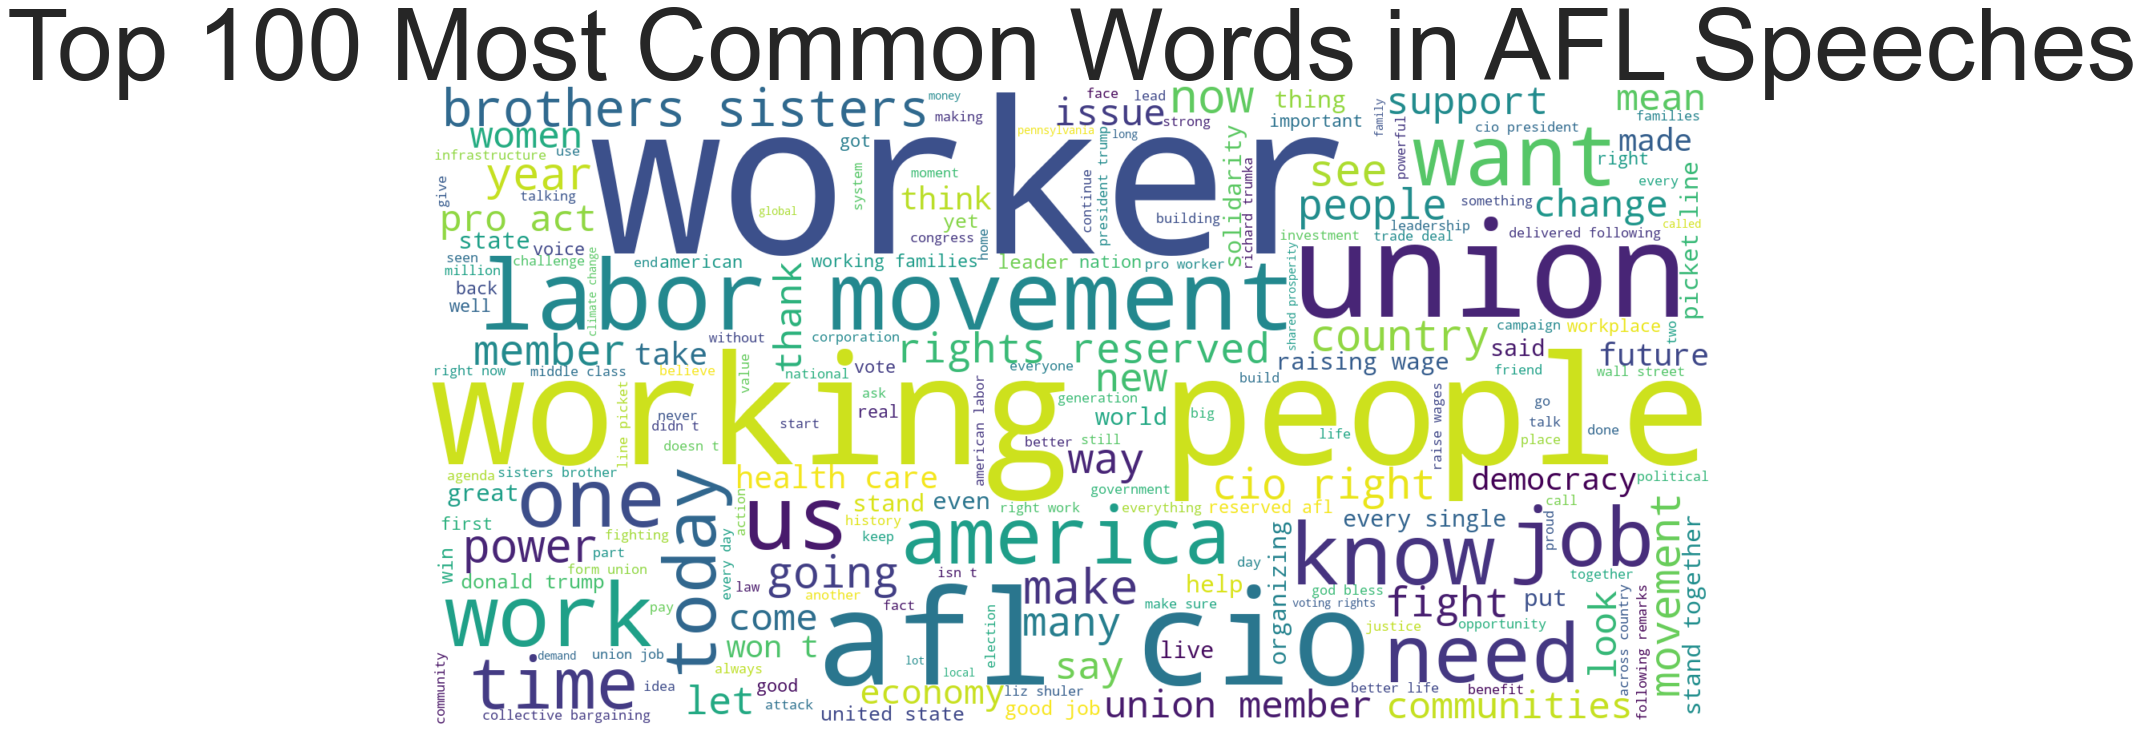

In [37]:
text = ' '.join(allwords)
mostcommon = FreqDist(text).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(text)
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words in AFL Speeches', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

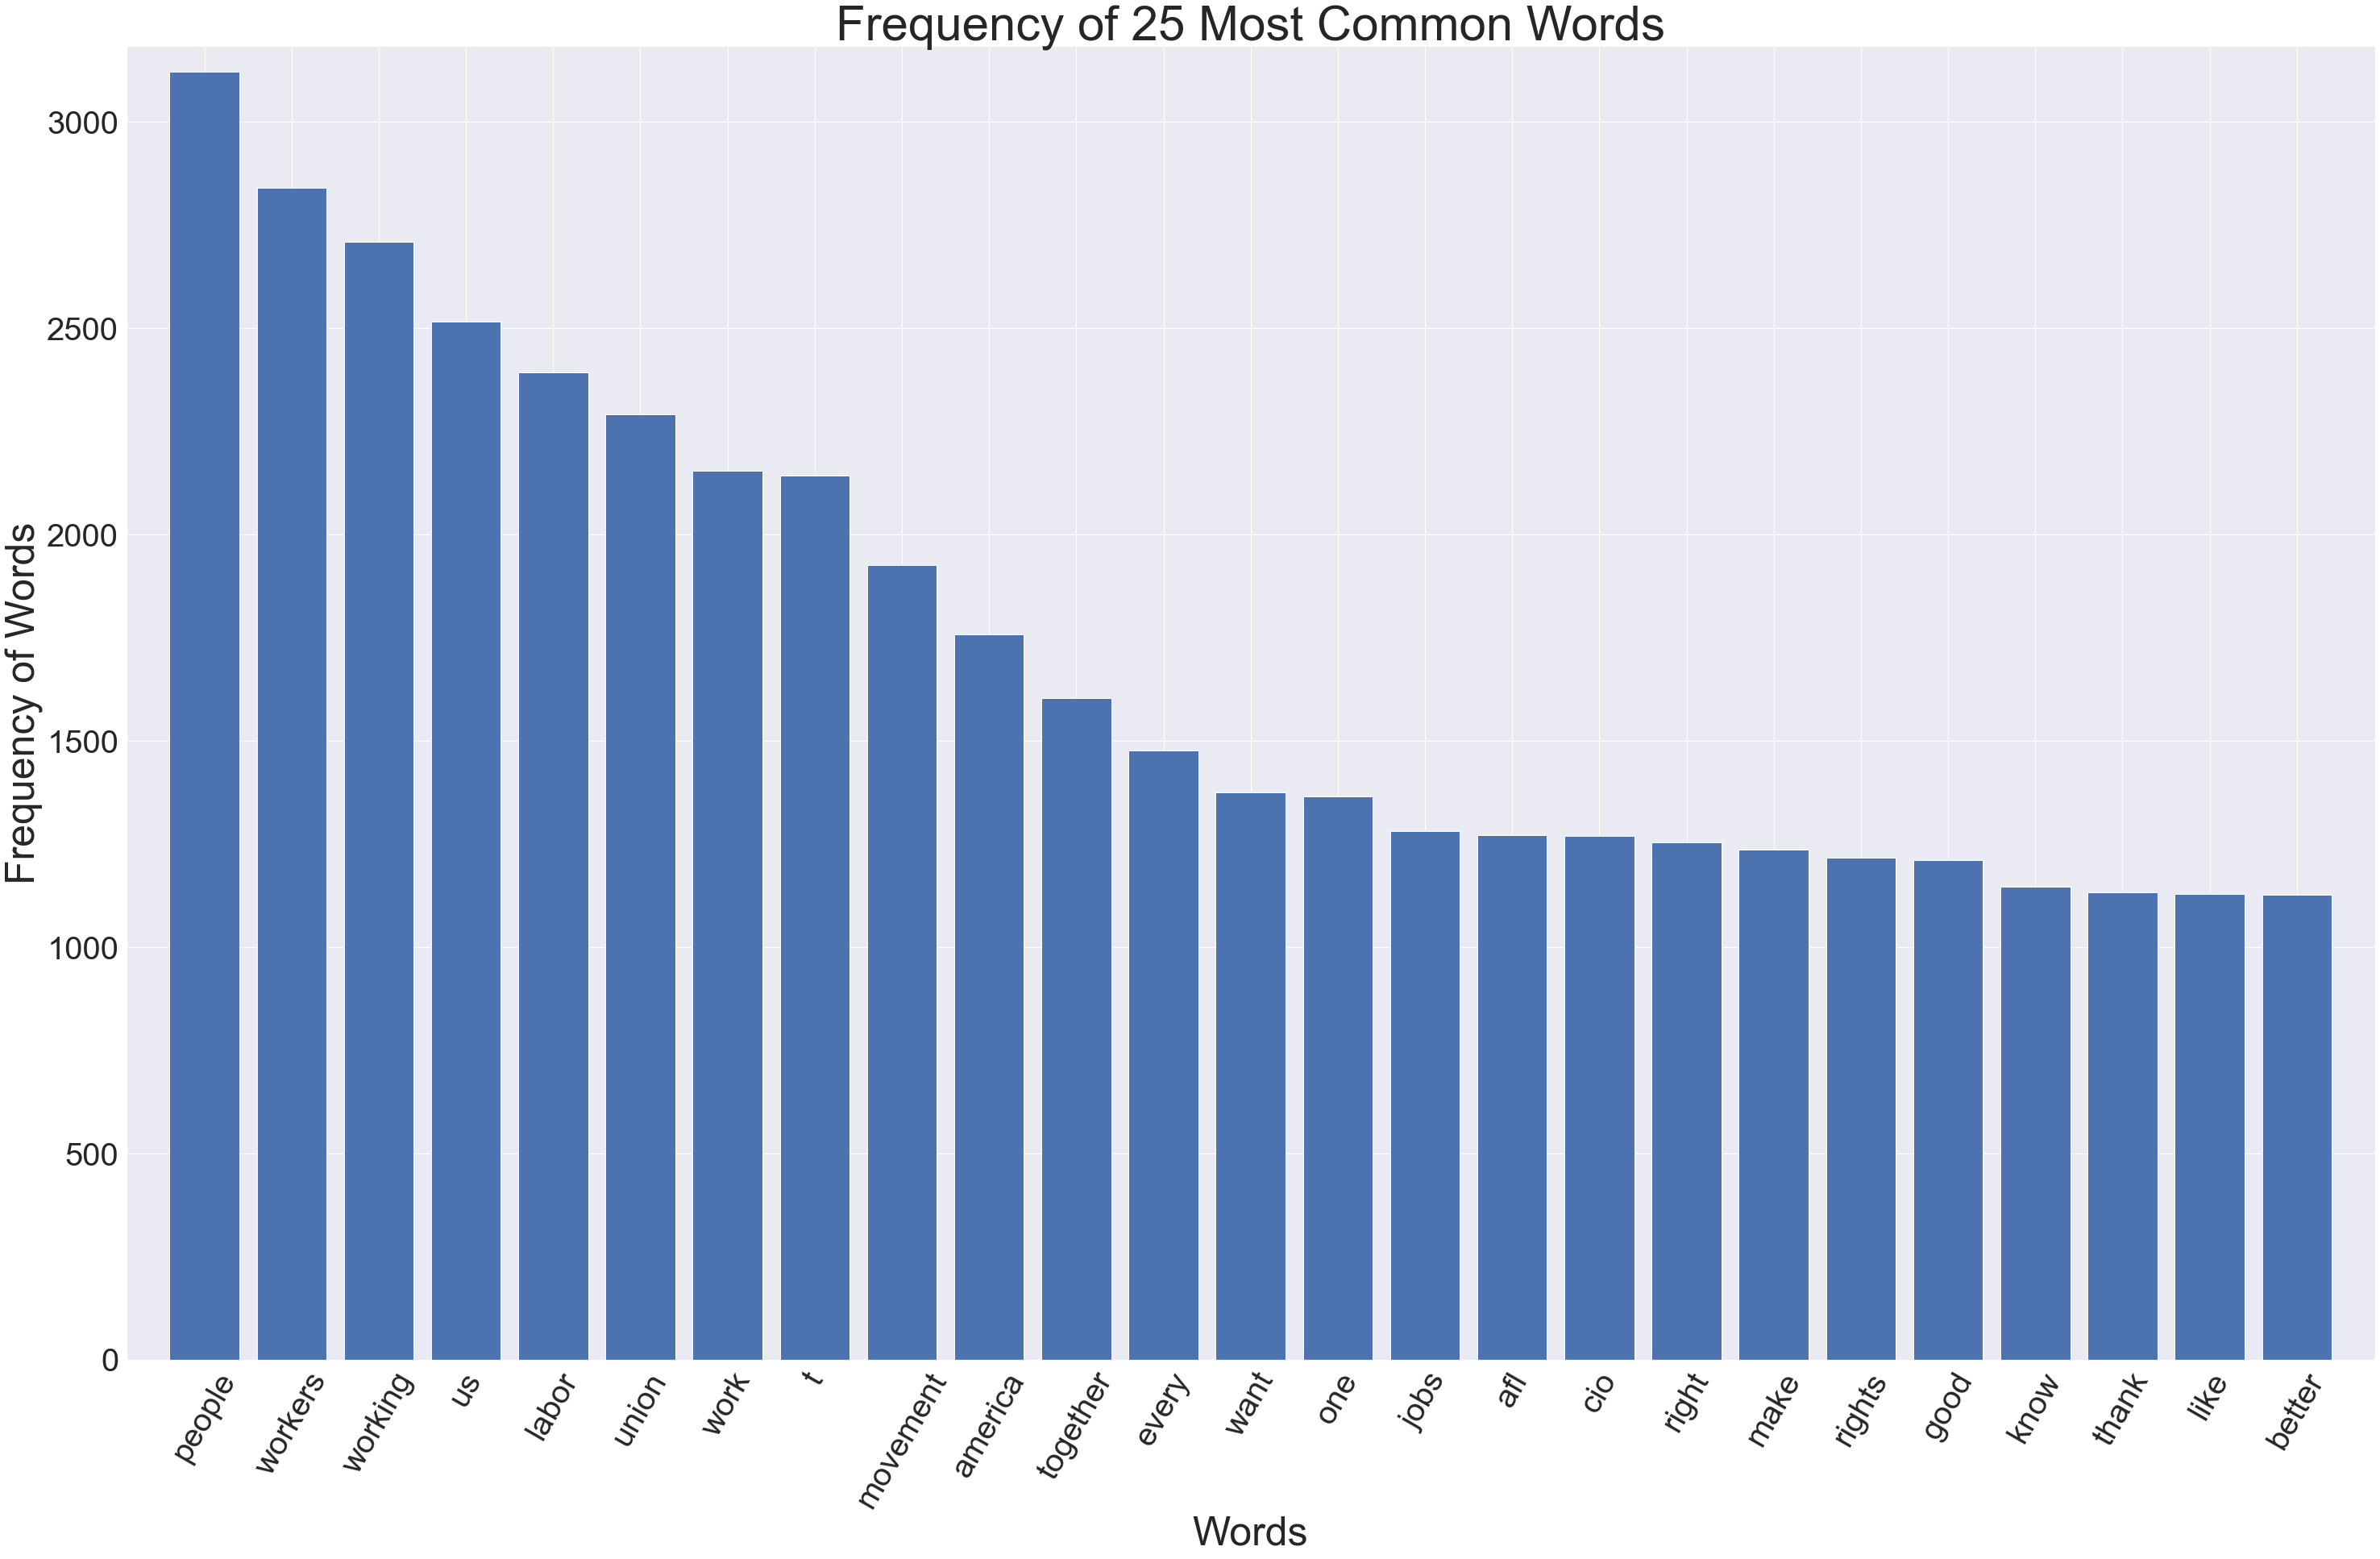

In [15]:
# plotting the frequency of the 25 most common words

mostcommon_small = FreqDist(allwords).most_common(25)
sns.set()
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words', fontsize=60)
plt.show()

In [16]:
from collections import Counter

In [17]:
#sentiment analysis

from textblob import TextBlob
# create a sentiment column and apply a polarity rating
df['sentiment'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df.head()

,Unnamed: 0,Speech Title,Url Link,Date,Speech Text,Speaker,clean_text,processed_clean,processed_clean_list,sentiment
0,0,Shuler: We Can Make Dr. King's Dream a Reality,https://aflcio.org/speeches/shuler-we-can-make...,1-13-2023,AFL-CIO President Liz Shuler delivered the fol...,Shuler,afl cio president liz shuler delivered followi...,afl cio president liz shuler delivered followi...,"[afl, cio, president, liz, shuler, delivered, ...",0.133537
1,1,Redmond: We Must Be That Mighty Force for Change,https://aflcio.org/speeches/redmond-we-must-be...,1-13-2023,AFL-CIO Secretary-Treasurer Fred Redmond deliv...,Redmond,afl cio secretary treasurer fred redmond deliv...,afl cio secretary treasurer fred redmond deliv...,"[afl, cio, secretary, treasurer, fred, redmond...",0.155295
2,2,Redmond: Technological Achievement Should Not ...,https://aflcio.org/speeches/redmond-technologi...,1-6-2023,AFL-CIO Secretary-Treasurer Fred Redmond's rem...,Redmond,afl cio secretary treasurer fred redmonds rema...,afl cio secretary treasurer fred redmonds rema...,"[afl, cio, secretary, treasurer, fred, redmond...",0.209458
3,3,Shuler: Innovation Should Empower Workers and ...,https://aflcio.org/speeches/shuler-innovation-...,1-6-2023,AFL-CIO President Liz Shuler's remarks as prep...,Shuler,afl cio president liz shulers remarks prepared...,afl cio president liz shulers remarks prepared...,"[afl, cio, president, liz, shulers, remarks, p...",0.161427
4,4,Redmond: We Need the Missouri Labor Movement N...,https://aflcio.org/speeches/redmond-we-need-mi...,8-22-2022,Secretary-Treasurer Fred Redmond delivered the...,Redmond,secretary treasurer fred redmond delivered fol...,secretary treasurer fred redmond delivered fol...,"[secretary, treasurer, fred, redmond, delivere...",0.229725


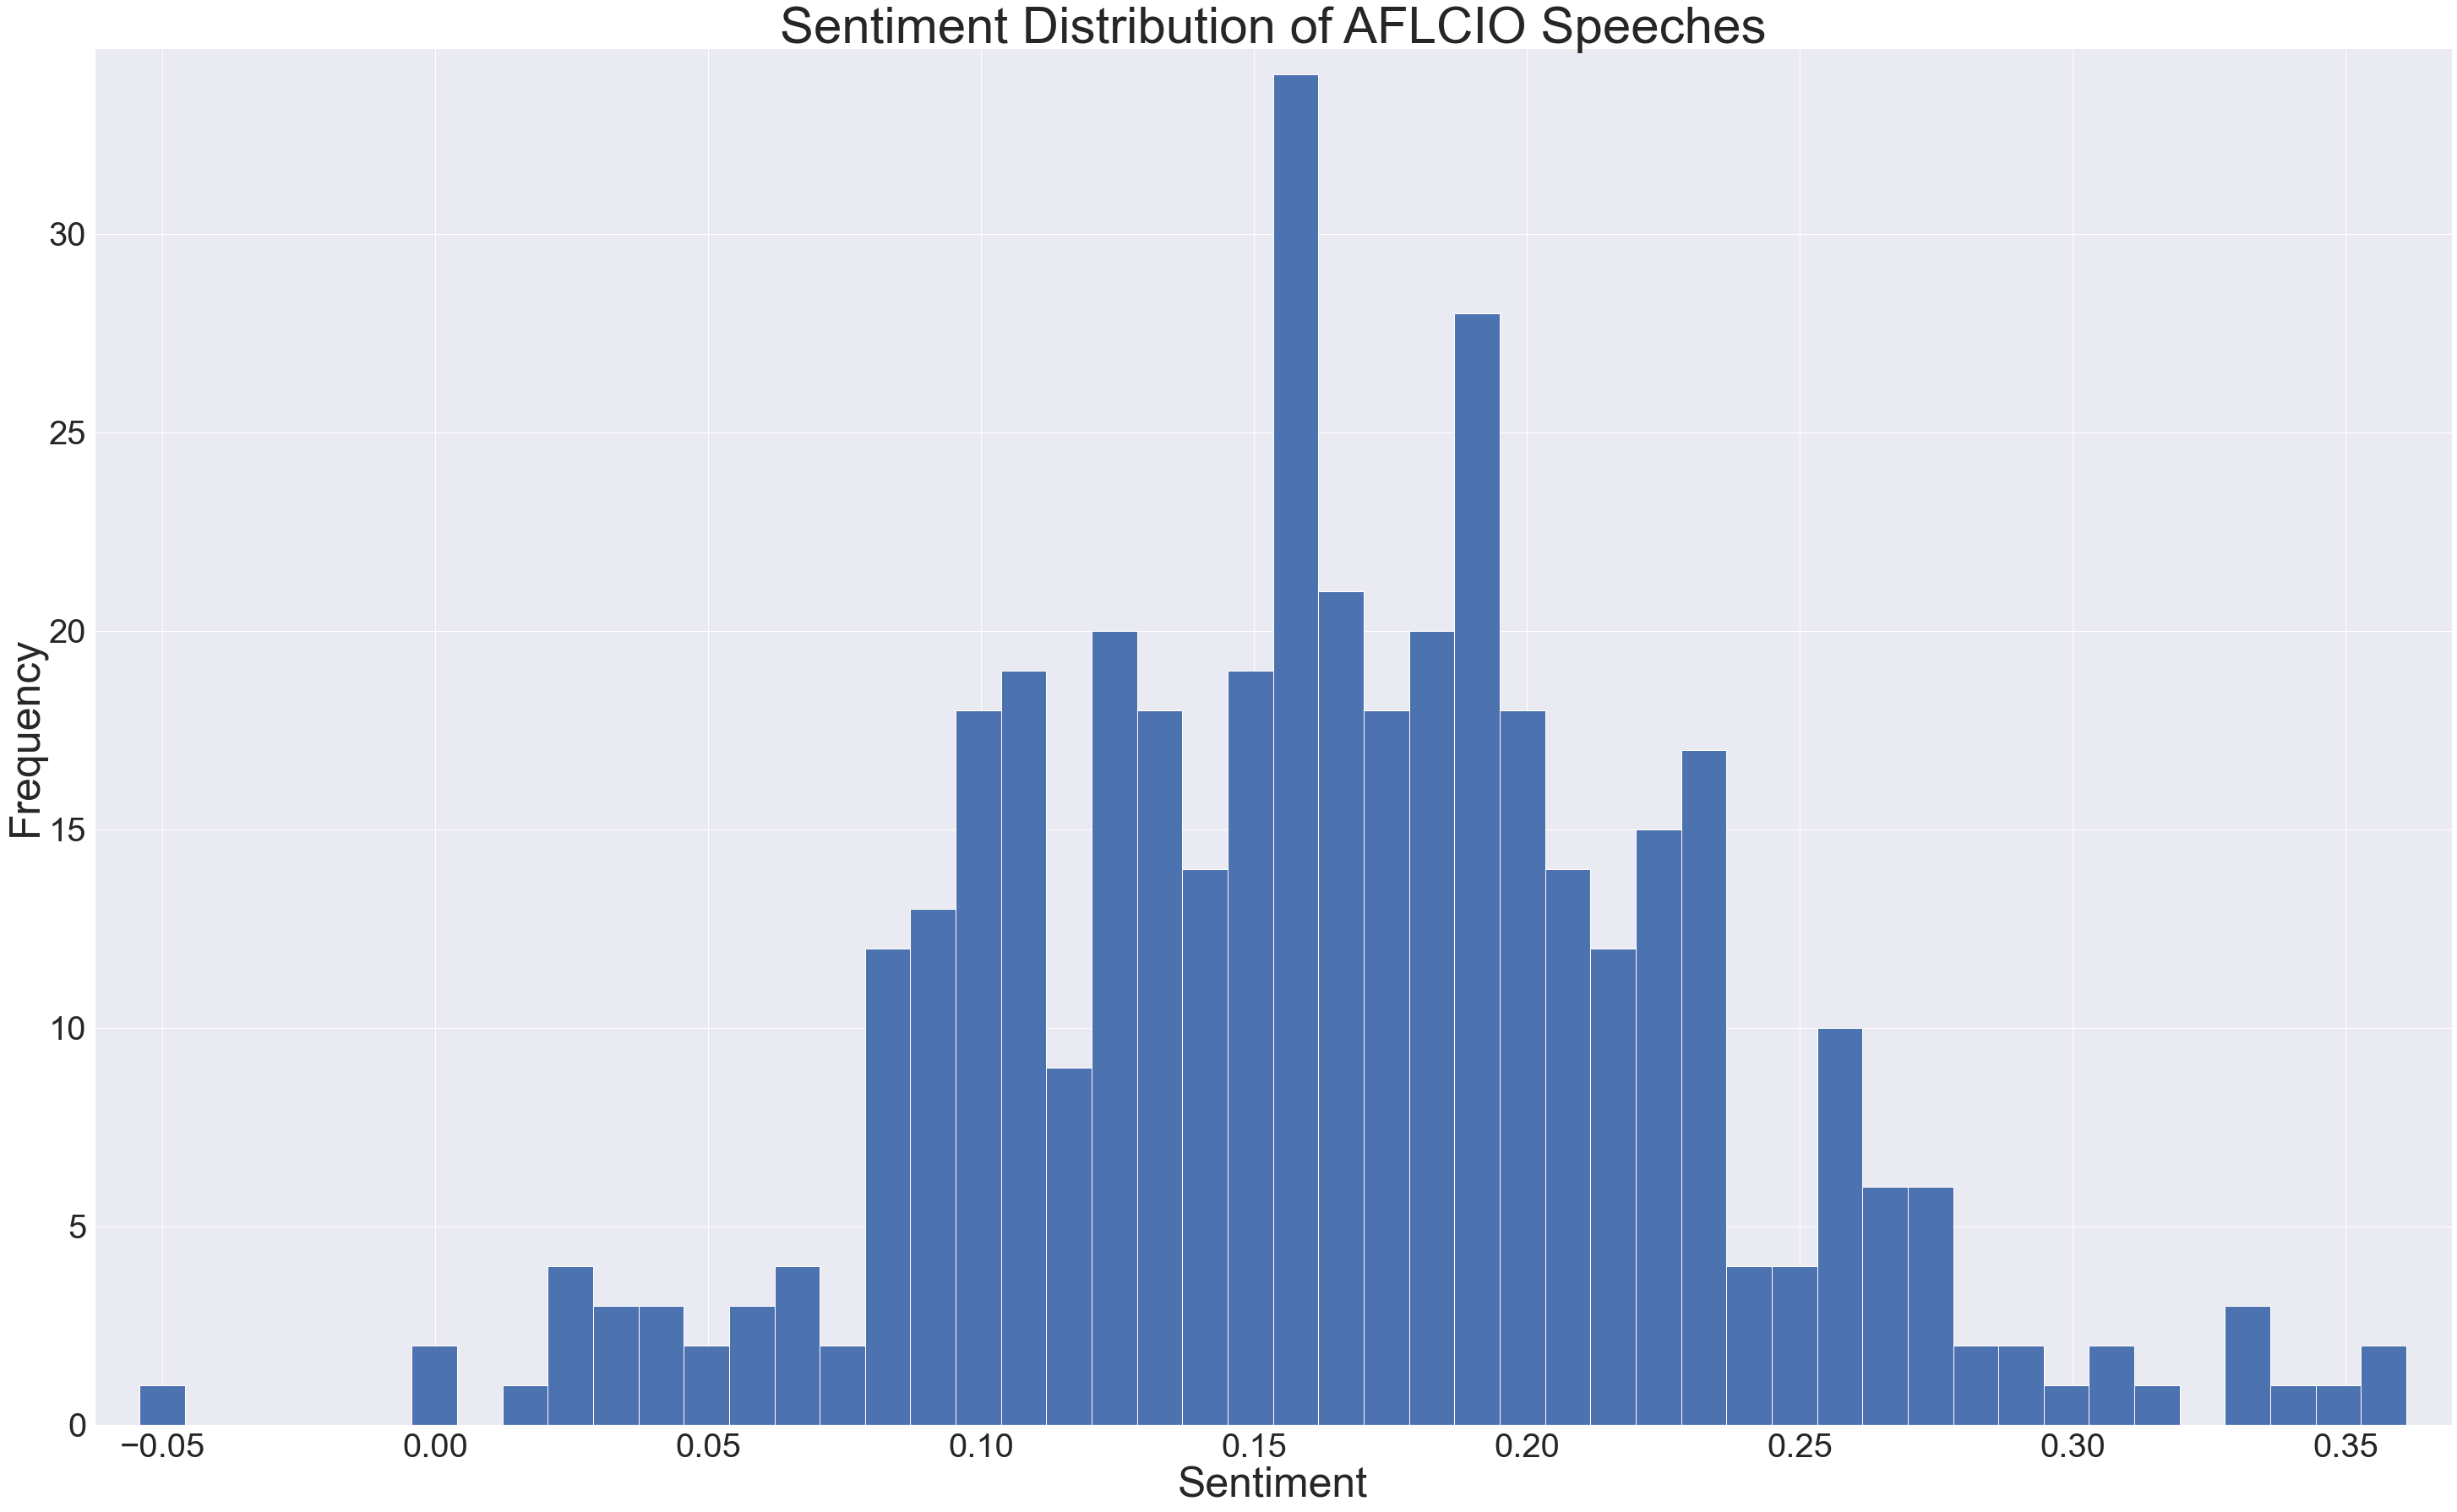

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# graph the sentiment distribution
sns.set()
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(df['sentiment'], bins=50)
plt.title('Sentiment Distribution of AFLCIO Speeches', fontsize=60)
plt.show()

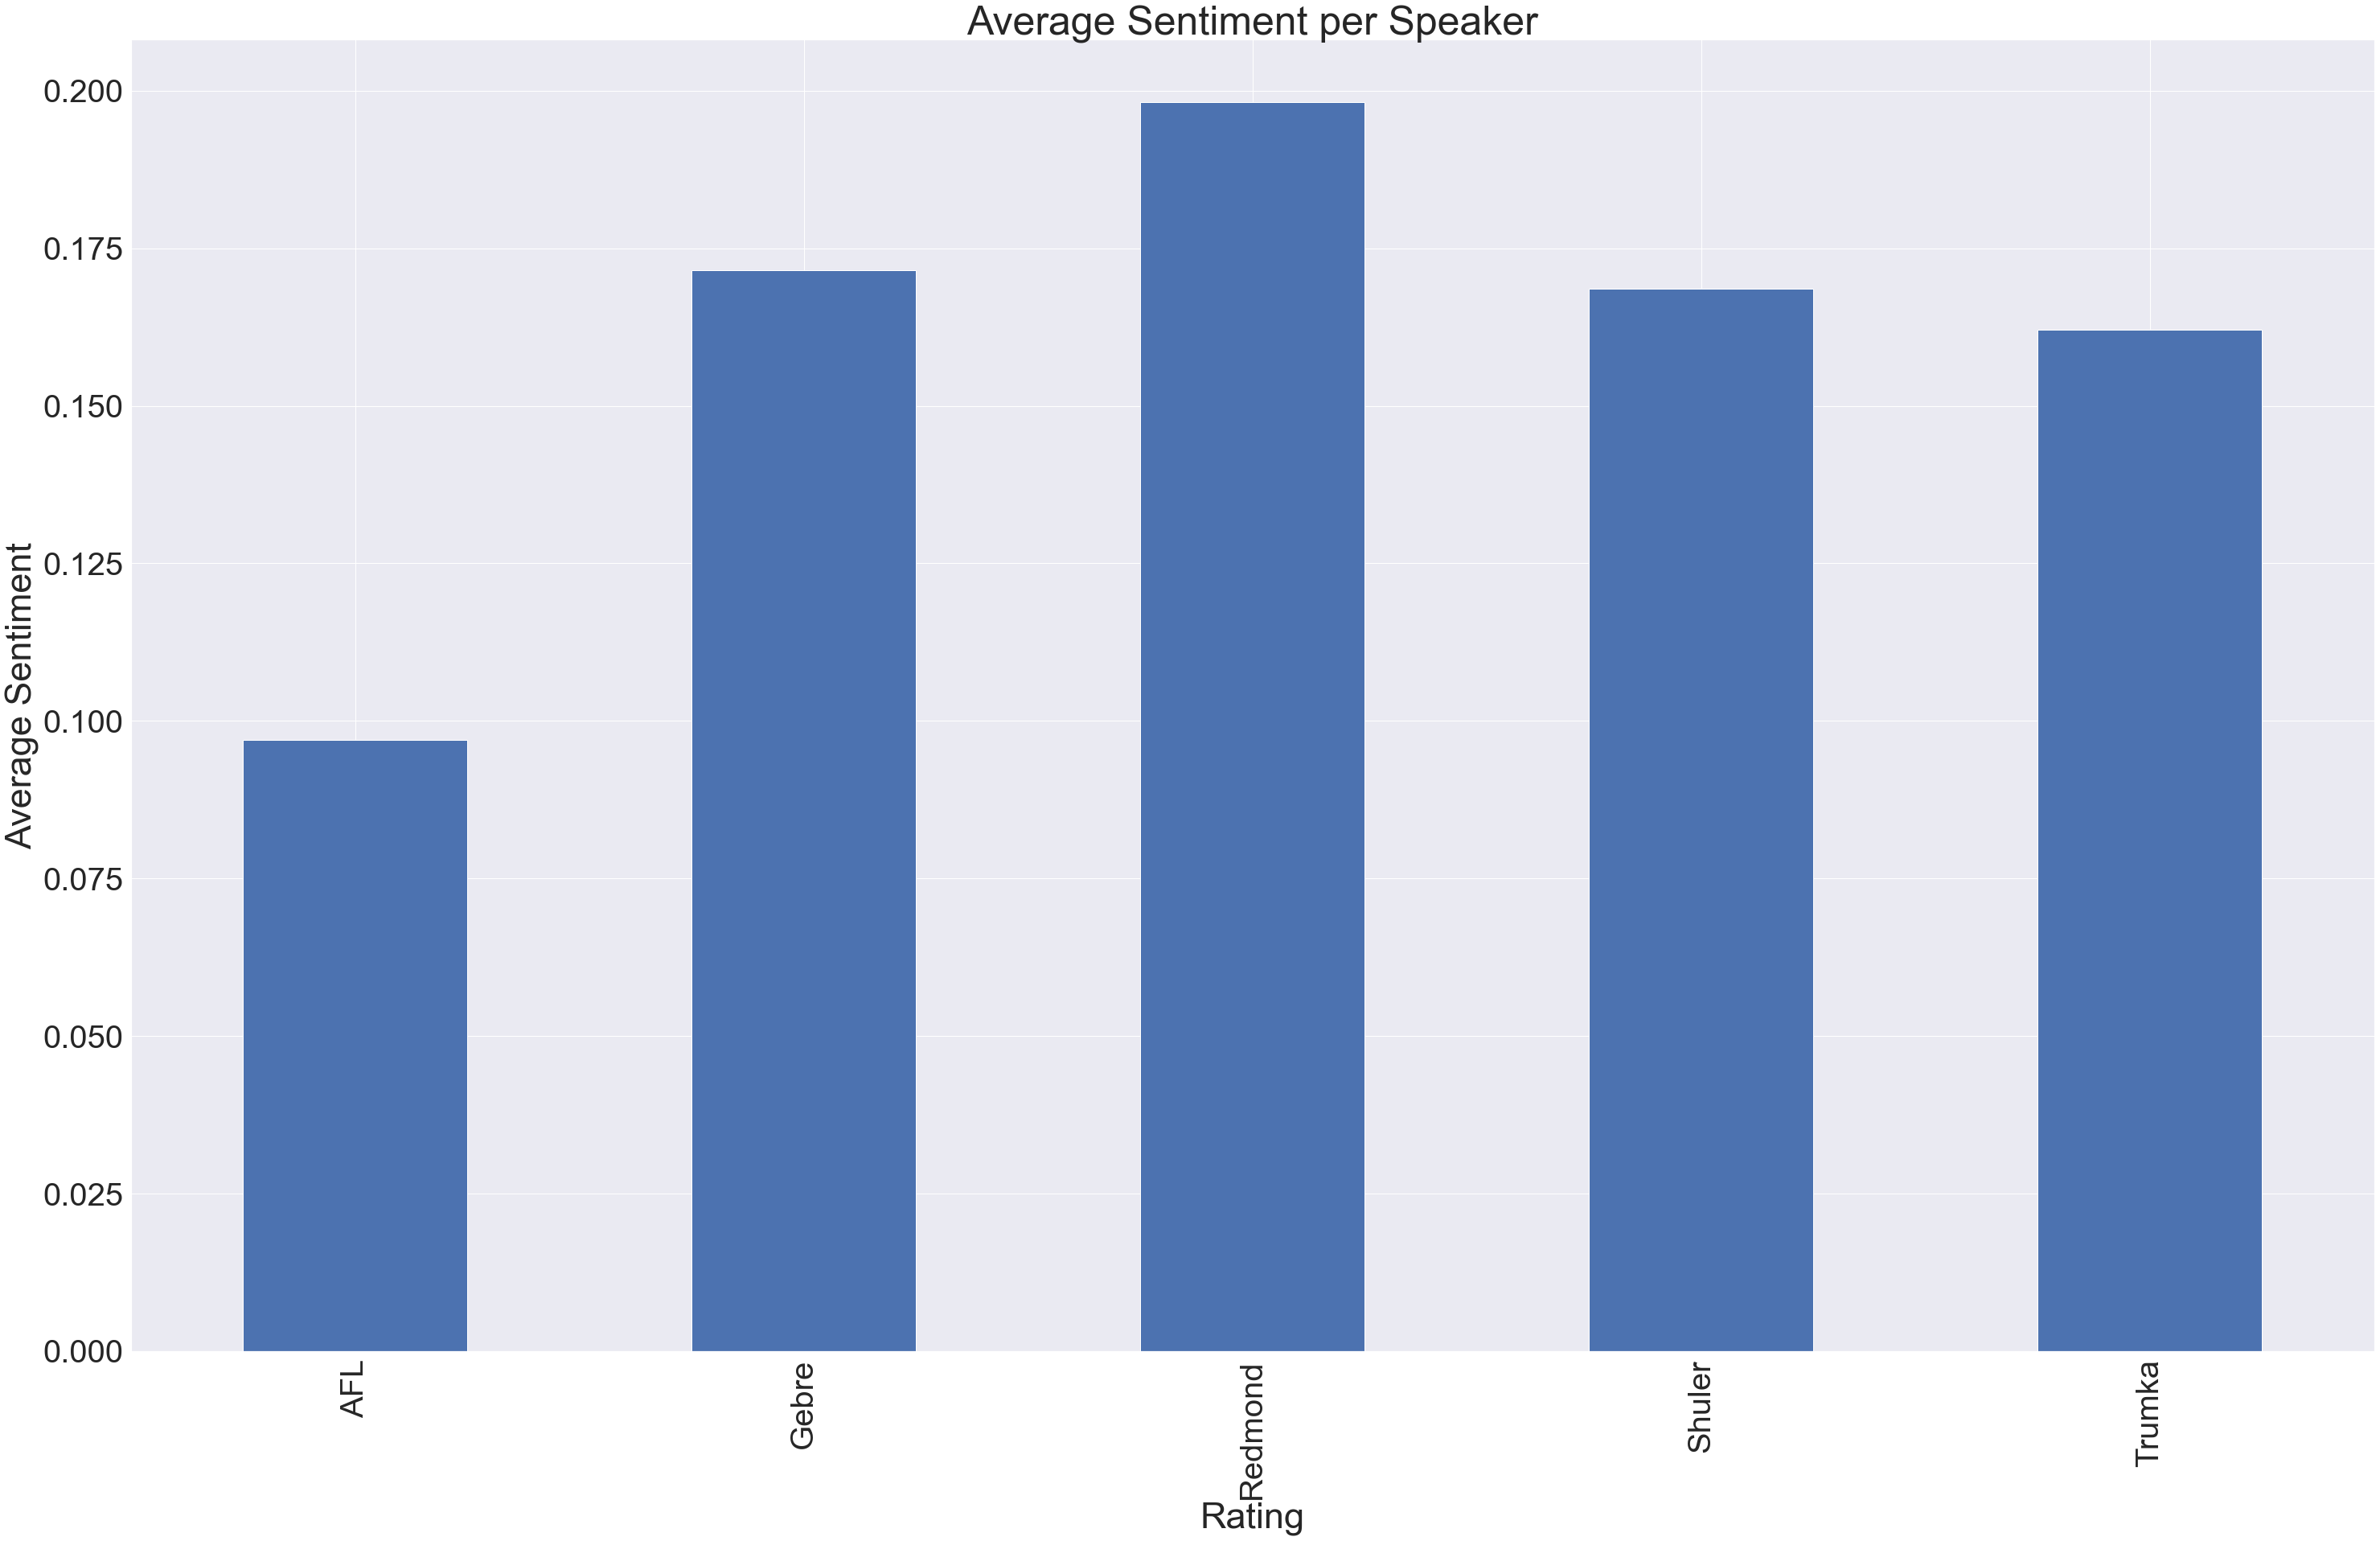

In [19]:
union_avg = df.groupby('Speaker')['sentiment'].mean().plot(kind='bar', figsize=(50,30))



plt.xlabel('Rating', fontsize=45)
plt.ylabel('Average Sentiment', fontsize=45)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Sentiment per Speaker', fontsize=50)
plt.show()

In [20]:
# looking at word count and length of tweet 
df['word_count'] = df['clean_text'].apply(lambda x: len(str(x).split()))
df['speech_len'] = df['clean_text'].astype(str).apply(len)

# look at df
df.head()

,Unnamed: 0,Speech Title,Url Link,Date,Speech Text,Speaker,clean_text,processed_clean,processed_clean_list,sentiment,word_count,speech_len
0,0,Shuler: We Can Make Dr. King's Dream a Reality,https://aflcio.org/speeches/shuler-we-can-make...,1-13-2023,AFL-CIO President Liz Shuler delivered the fol...,Shuler,afl cio president liz shuler delivered followi...,afl cio president liz shuler delivered followi...,"[afl, cio, president, liz, shuler, delivered, ...",0.133537,584,3976
1,1,Redmond: We Must Be That Mighty Force for Change,https://aflcio.org/speeches/redmond-we-must-be...,1-13-2023,AFL-CIO Secretary-Treasurer Fred Redmond deliv...,Redmond,afl cio secretary treasurer fred redmond deliv...,afl cio secretary treasurer fred redmond deliv...,"[afl, cio, secretary, treasurer, fred, redmond...",0.155295,636,4395
2,2,Redmond: Technological Achievement Should Not ...,https://aflcio.org/speeches/redmond-technologi...,1-6-2023,AFL-CIO Secretary-Treasurer Fred Redmond's rem...,Redmond,afl cio secretary treasurer fred redmonds rema...,afl cio secretary treasurer fred redmonds rema...,"[afl, cio, secretary, treasurer, fred, redmond...",0.209458,342,2531
3,3,Shuler: Innovation Should Empower Workers and ...,https://aflcio.org/speeches/shuler-innovation-...,1-6-2023,AFL-CIO President Liz Shuler's remarks as prep...,Shuler,afl cio president liz shulers remarks prepared...,afl cio president liz shulers remarks prepared...,"[afl, cio, president, liz, shulers, remarks, p...",0.161427,351,2645
4,4,Redmond: We Need the Missouri Labor Movement N...,https://aflcio.org/speeches/redmond-we-need-mi...,8-22-2022,Secretary-Treasurer Fred Redmond delivered the...,Redmond,secretary treasurer fred redmond delivered fol...,secretary treasurer fred redmond delivered fol...,"[secretary, treasurer, fred, redmond, delivere...",0.229725,589,4138


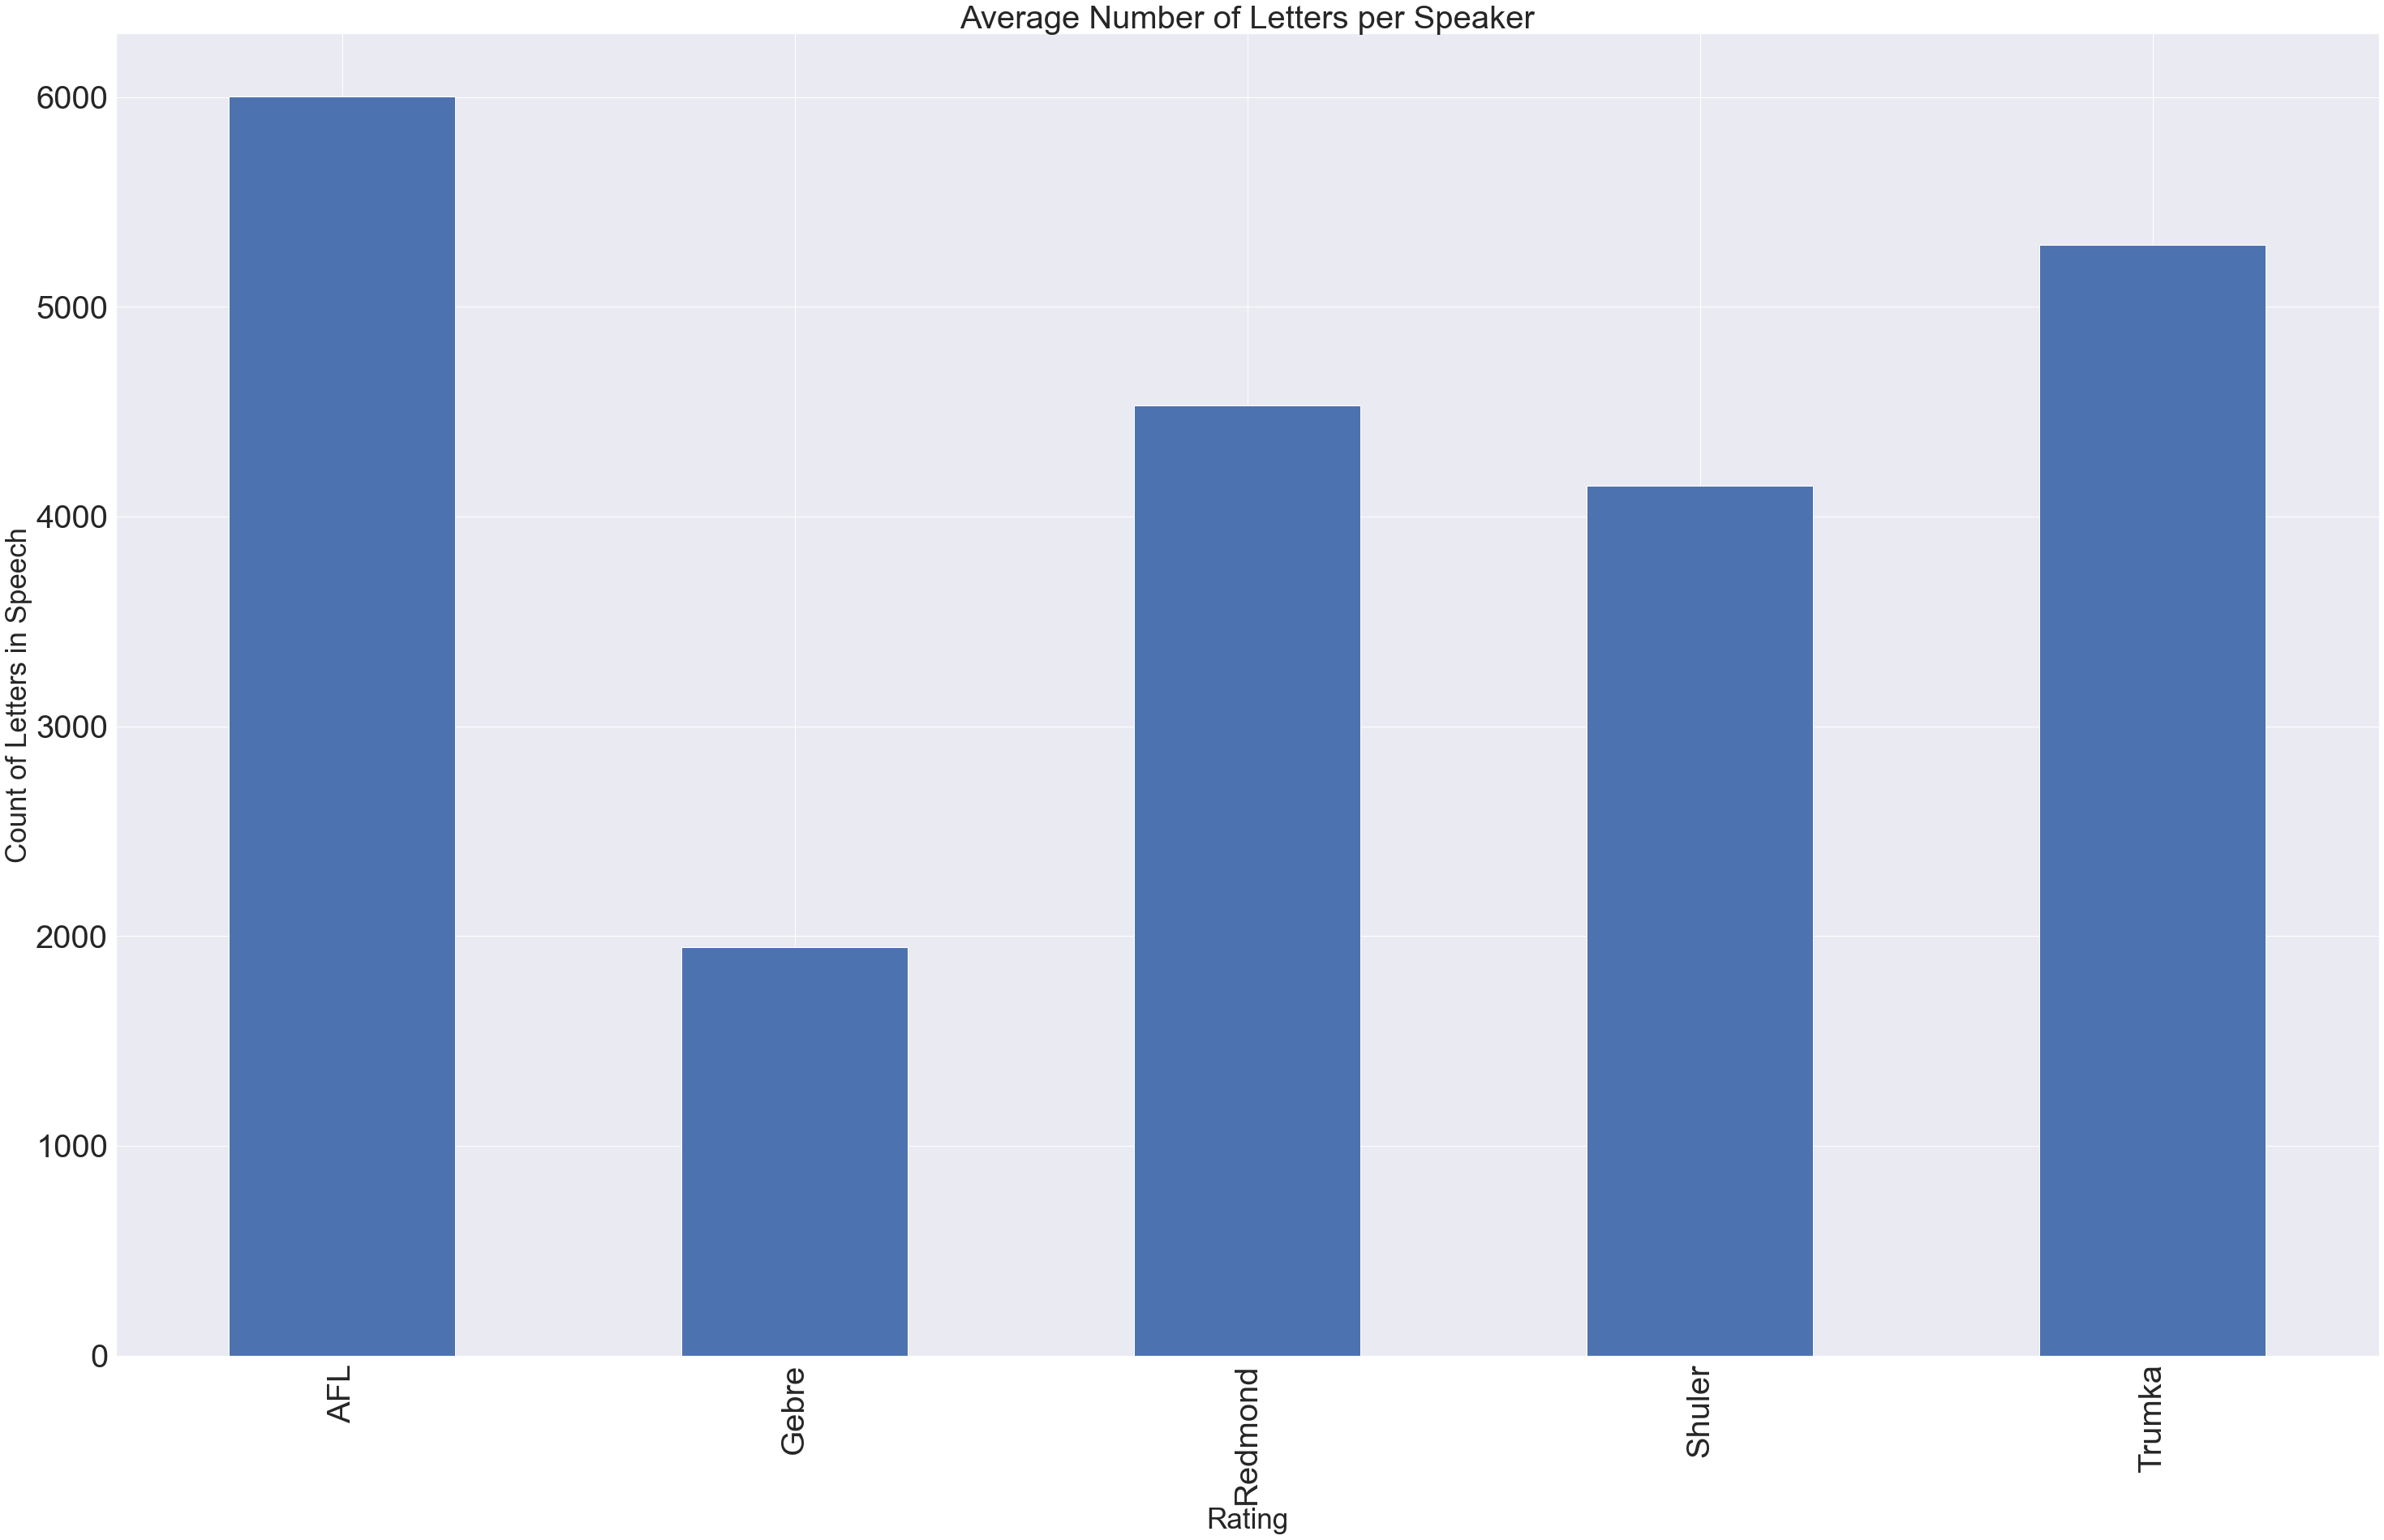

In [21]:
# Graphing tweet length

letter_avg = df.groupby('Speaker')['speech_len'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Rating', fontsize=35)
plt.ylabel('Count of Letters in Speech', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Number of Letters per Speaker', fontsize=40)
plt.show()

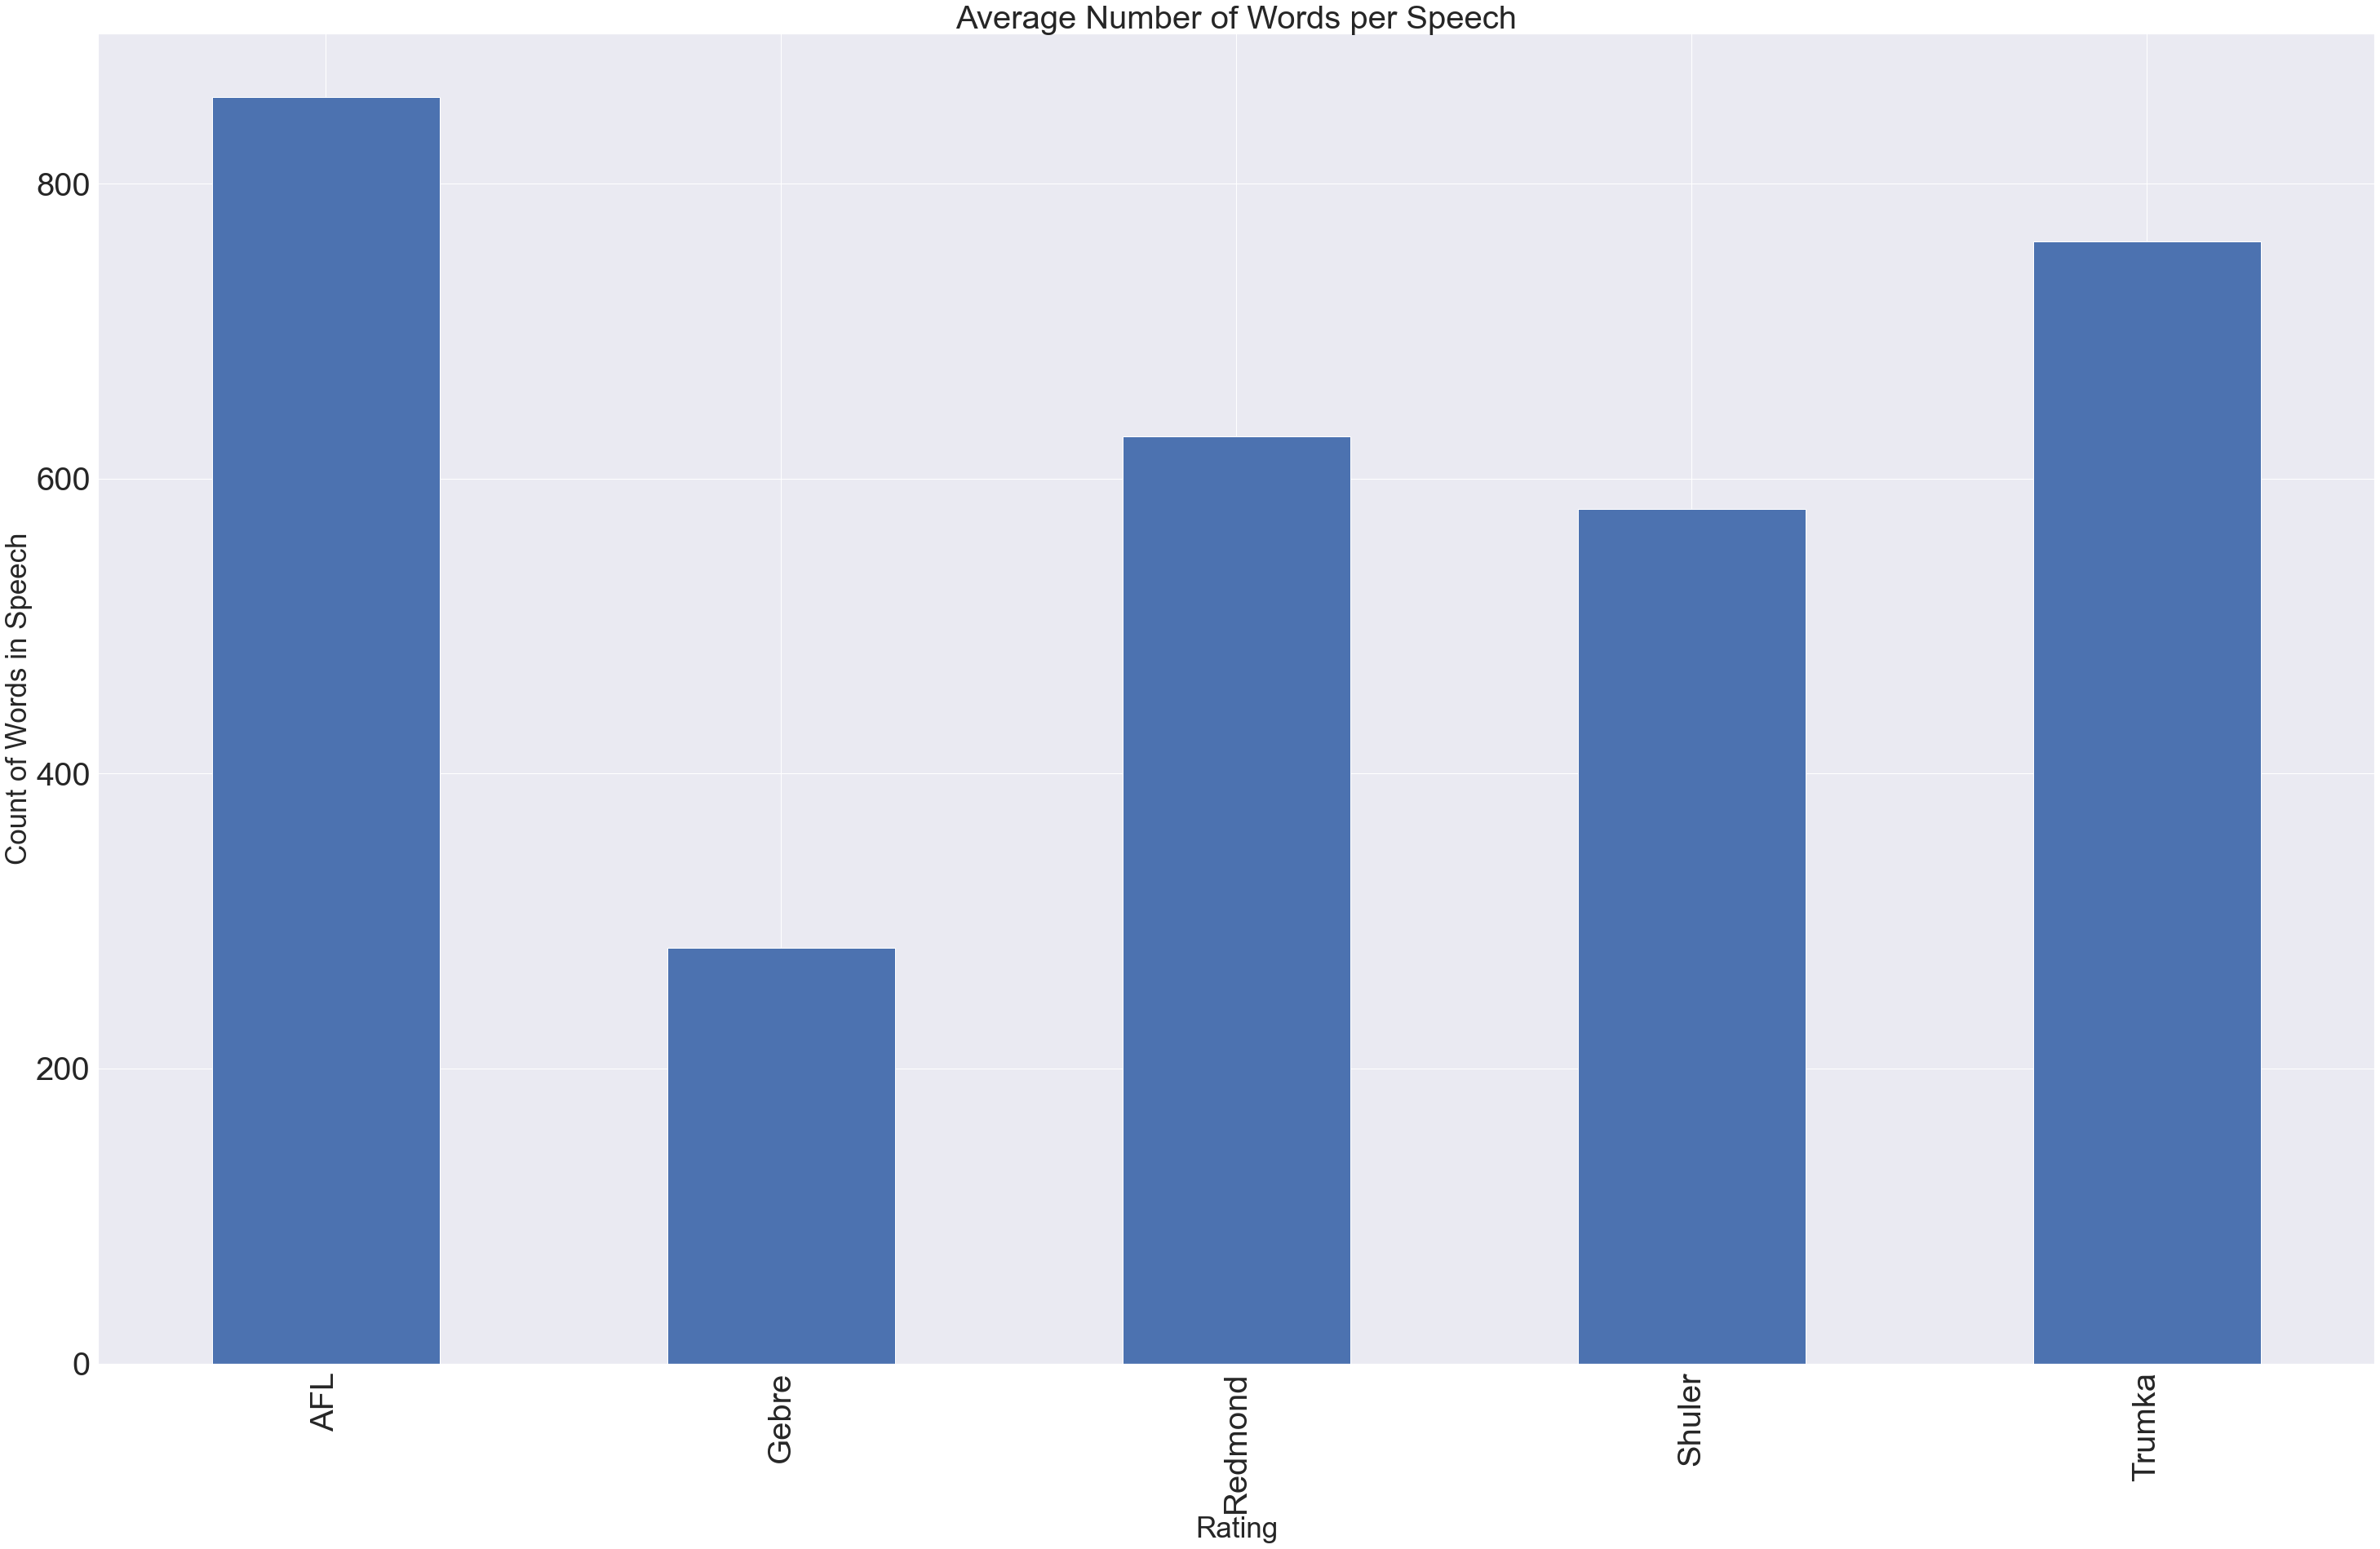

In [22]:
# graphic word count

word_avg = df.groupby('Speaker')['word_count'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Rating', fontsize=35)
plt.ylabel('Count of Words in Speech', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Number of Words per Speech', fontsize=40)
plt.show()

<ipython-input-23-65b12b1d923a>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df[['Speaker','sentiment', 'speech_len', 'word_count']].corr()
<ipython-input-23-65b12b1d923a>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(correlation, dtype=np.bool)


<AxesSubplot:>

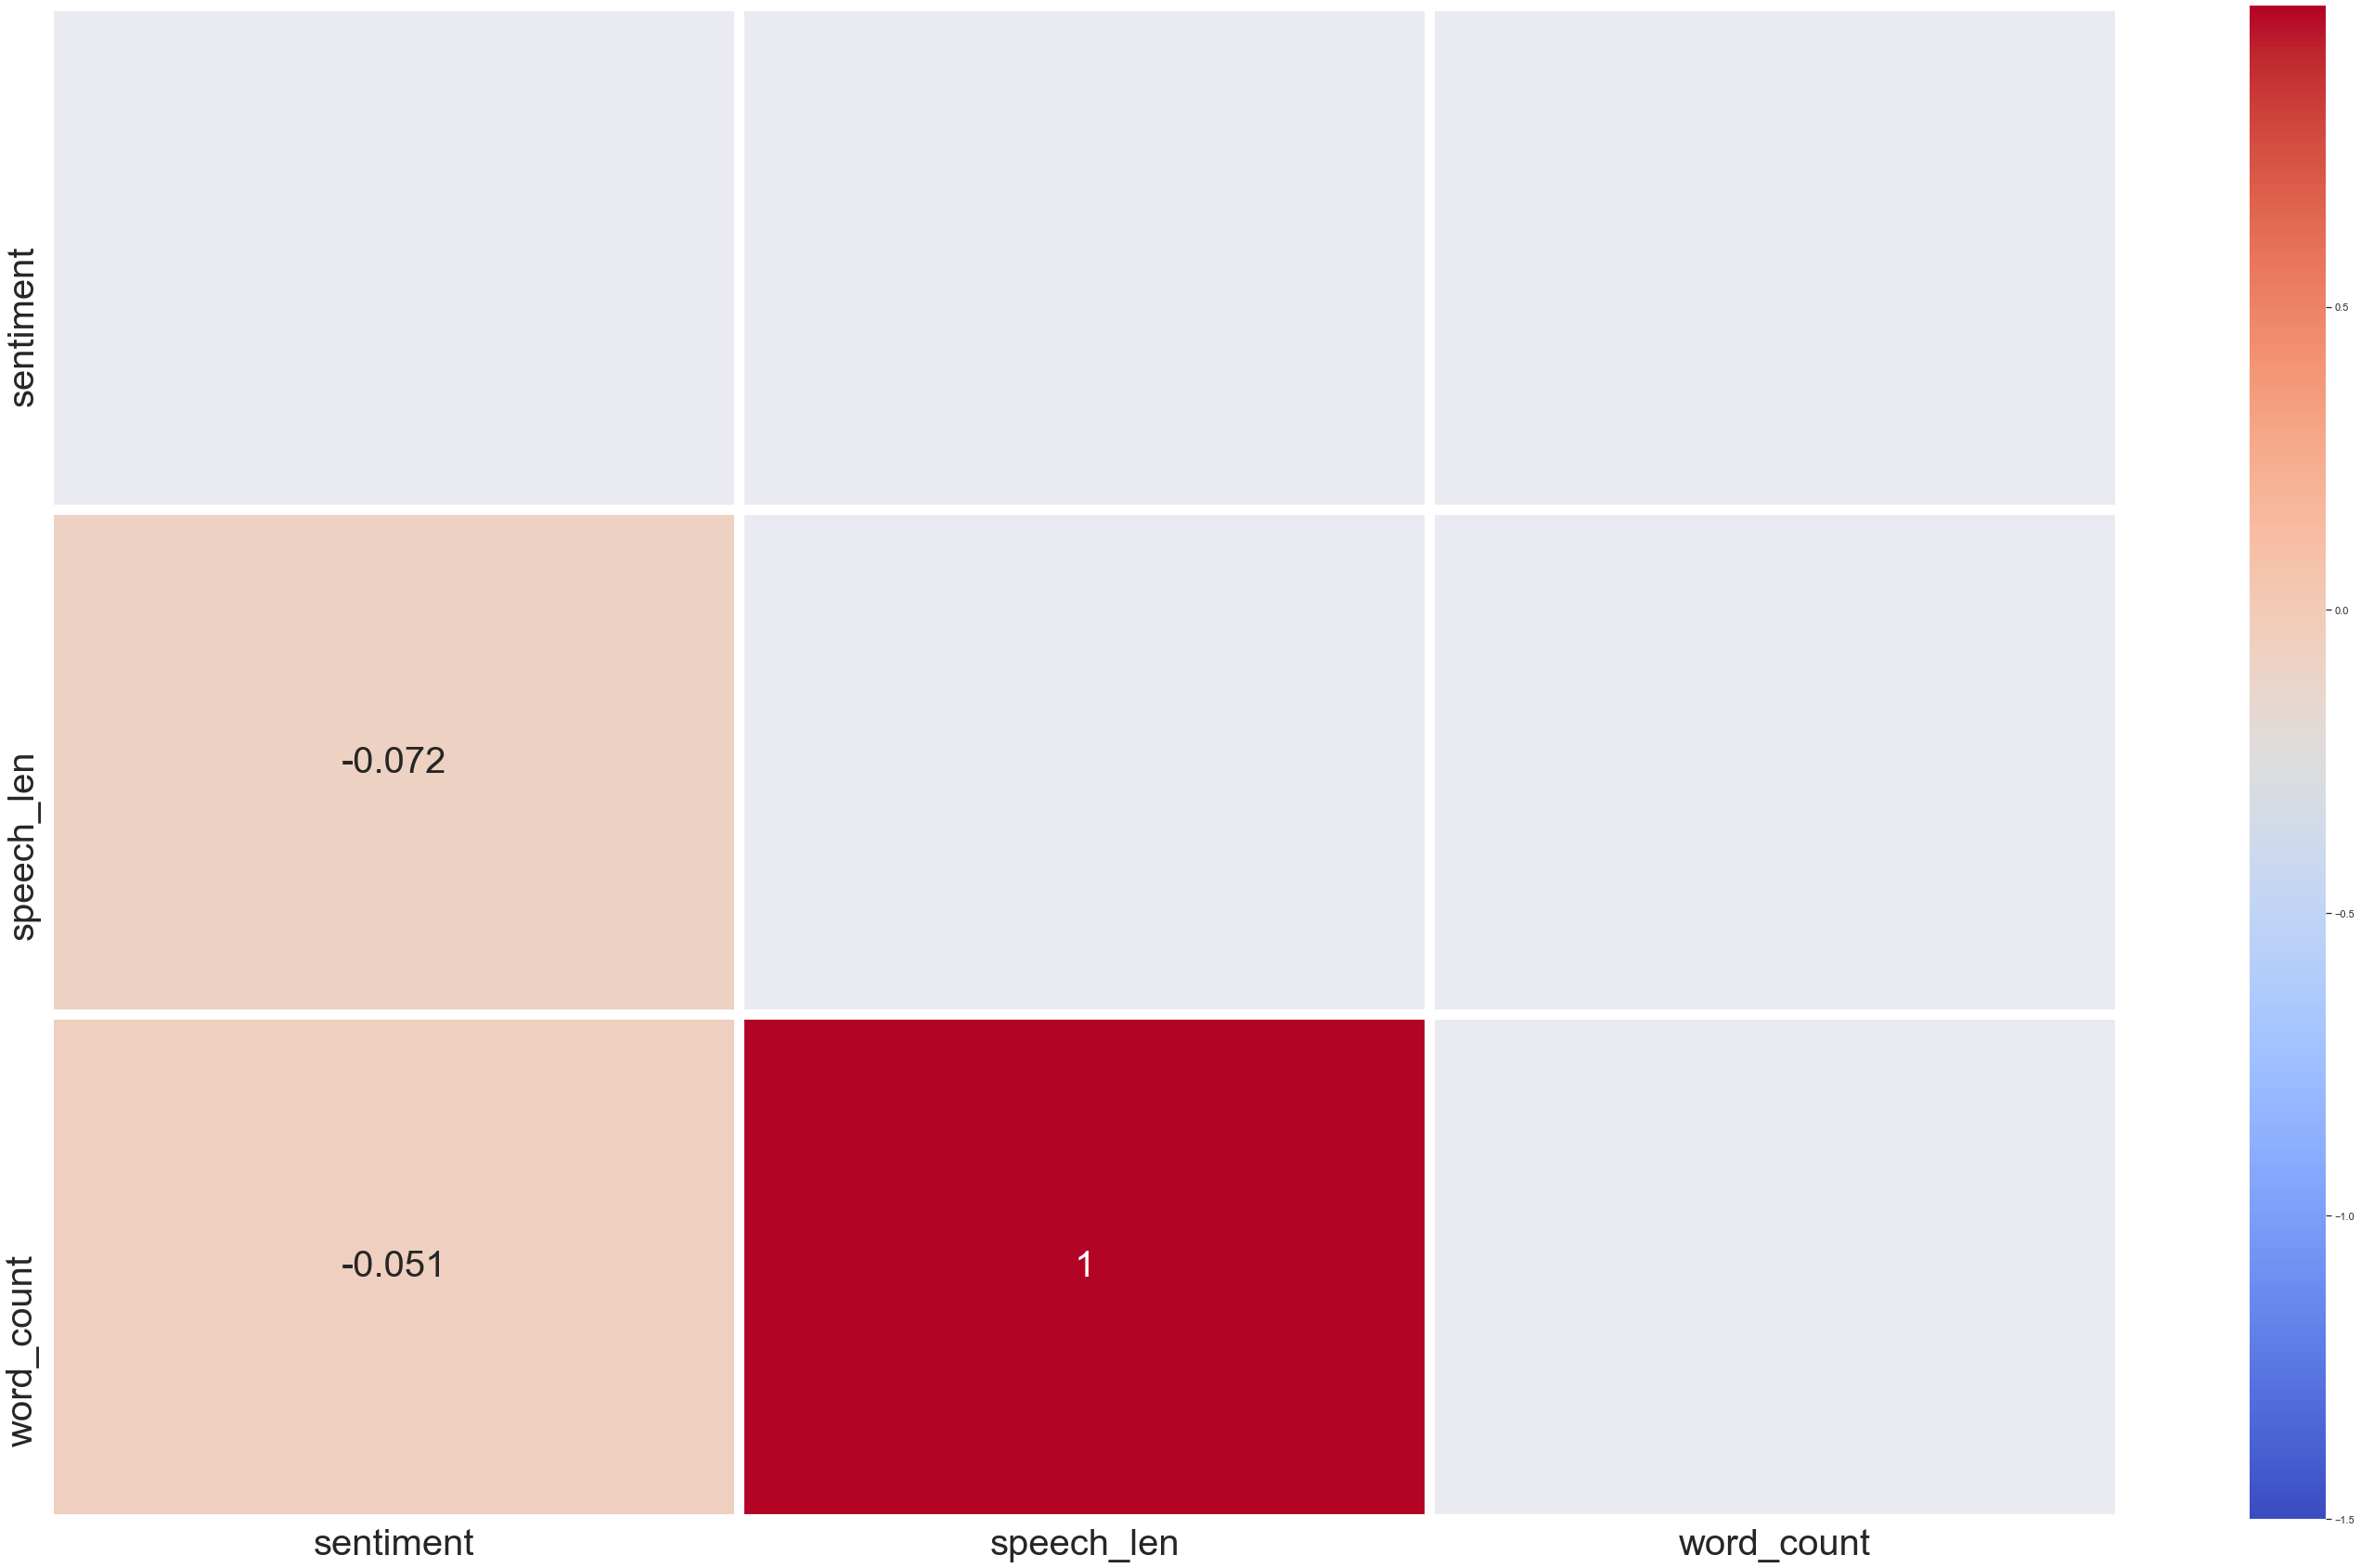

In [23]:
# correlating word/review length, sentiment 

correlation = df[['Speaker','sentiment', 'speech_len', 'word_count']].corr()
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(50,30))
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
sns.heatmap(correlation, cmap='coolwarm', annot=True, annot_kws={"size": 40}, linewidths=10, vmin=-1.5, mask=mask)

In [24]:
# plotting sentiment over time 

from datetime import datetime

def parse_date(date_string):
    return datetime.strptime(date_string, '%m-%d-%Y')


In [25]:
df['datetime'] = df['Date'].apply(parse_date)

In [26]:
# plotting sentiment over time 

# first, we need to apply the datetime function to group together the months of data,
# then we want to average the sentiment for each month

from datetime import datetime

def get_month_year(dt):
    month_year = dt.strftime('%B %Y')
    return month_year


df['month_year'] = df['datetime'].apply(get_month_year)

In [27]:
import datetime

def get_year(date_object):
   
    year = date_object.year
    return year


df['year'] = df['datetime'].apply(get_year)

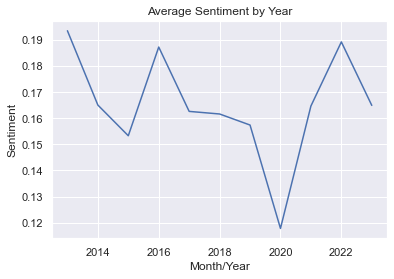

In [28]:
import matplotlib.pyplot as plt

# Group by month_year and calculate the mean sentiment for each group
df_grouped = df.groupby('year')['sentiment'].mean()

# Plot the results as a line chart
df_grouped.plot(kind='line')

sns.set()
# Add a title and axis labels
plt.title('Average Sentiment by Year')
plt.xlabel('Month/Year')
plt.ylabel('Sentiment')

# Display the plot
plt.show()


In [29]:
# plotting the number of speeches each year

value_counts = df['year'].value_counts()

value_counts

2021    88
2018    54
2016    47
2019    44
2022    42
2017    41
2014    31
2020    26
2015    23
2013     9
2023     4
Name: year, dtype: int64

Text(0.5, 1.0, 'Value Counts')

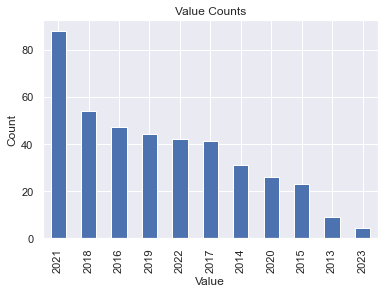

In [30]:
# create a bar plot of the value counts
ax = value_counts.plot.bar()

# set the axis labels and title
ax.set_xlabel("Value")
ax.set_ylabel("Count")
ax.set_title("Value Counts")

In [31]:
df

,Unnamed: 0,Speech Title,Url Link,Date,Speech Text,Speaker,clean_text,processed_clean,processed_clean_list,sentiment,word_count,speech_len,datetime,month_year,year
0,0,Shuler: We Can Make Dr. King's Dream a Reality,https://aflcio.org/speeches/shuler-we-can-make...,1-13-2023,AFL-CIO President Liz Shuler delivered the fol...,Shuler,afl cio president liz shuler delivered followi...,afl cio president liz shuler delivered followi...,"[afl, cio, president, liz, shuler, delivered, ...",0.133537,584,3976,2023-01-13,January 2023,2023
1,1,Redmond: We Must Be That Mighty Force for Change,https://aflcio.org/speeches/redmond-we-must-be...,1-13-2023,AFL-CIO Secretary-Treasurer Fred Redmond deliv...,Redmond,afl cio secretary treasurer fred redmond deliv...,afl cio secretary treasurer fred redmond deliv...,"[afl, cio, secretary, treasurer, fred, redmond...",0.155295,636,4395,2023-01-13,January 2023,2023
2,2,Redmond: Technological Achievement Should Not ...,https://aflcio.org/speeches/redmond-technologi...,1-6-2023,AFL-CIO Secretary-Treasurer Fred Redmond's rem...,Redmond,afl cio secretary treasurer fred redmonds rema...,afl cio secretary treasurer fred redmonds rema...,"[afl, cio, secretary, treasurer, fred, redmond...",0.209458,342,2531,2023-01-06,January 2023,2023
3,3,Shuler: Innovation Should Empower Workers and ...,https://aflcio.org/speeches/shuler-innovation-...,1-6-2023,AFL-CIO President Liz Shuler's remarks as prep...,Shuler,afl cio president liz shulers remarks prepared...,afl cio president liz shulers remarks prepared...,"[afl, cio, president, liz, shulers, remarks, p...",0.161427,351,2645,2023-01-06,January 2023,2023
4,4,Redmond: We Need the Missouri Labor Movement N...,https://aflcio.org/speeches/redmond-we-need-mi...,8-22-2022,Secretary-Treasurer Fred Redmond delivered the...,Redmond,secretary treasurer fred redmond delivered fol...,secretary treasurer fred redmond delivered fol...,"[secretary, treasurer, fred, redmond, delivere...",0.229725,589,4138,2022-08-22,August 2022,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,404,Shuler 2013 AFL-CIO Convention Acceptance,https://aflcio.org/speeches/shuler-2013-afl-ci...,9-10-2013,Wow! Thank you. Thank you all so much.Brother...,Shuler,wow thank thank brothers sisters true joy stan...,wow thank thank brothers sisters true joy stan...,"[wow, thank, thank, brothers, sisters, true, j...",0.157714,662,4622,2013-09-10,September 2013,2013
405,405,Gebre 2013 AFL-CIO Convention Acceptance,https://aflcio.org/speeches/gebre-2013-afl-cio...,9-10-2013,"Thank you, brothers and sisters, for your conf...",Gebre,thank brothers sisters confidence want thank j...,thank brothers sisters confidence want thank j...,"[thank, brothers, sisters, confidence, want, t...",0.293209,422,2897,2013-09-10,September 2013,2013
406,406,Trumka 2013 AFL-CIO Convention Keynote,https://aflcio.org/speeches/trumka-2013-afl-ci...,9-9-2013,Thank you. Thank you for being here. Together...,Trumka,thank thank together solidarity look around gr...,thank thank together solidarity look around gr...,"[thank, thank, together, solidarity, look, aro...",0.189009,1729,11970,2013-09-09,September 2013,2013
407,407,Remarks of AFL-CIO President Richard L. Trumka...,https://aflcio.org/speeches/remarks-afl-cio-pr...,9-6-2013,Thank you for all for coming together here in ...,Trumka,thank coming together los angeles thank kind i...,thank coming together los angeles thank kind i...,"[thank, coming, together, los, angeles, thank,...",0.176759,797,5475,2013-09-06,September 2013,2013


In [32]:
def convert_to_quarter(df):
    results = {}
    for d in df.iterrows():
        # get the date
        year, month, day = d[1][-3].strftime('%Y-%m-%d').split("-")
        
        # save the new year if not exists
        if year not in results.keys():
            # add the year
            results[year] = {}
            
        # compute the quarter id 
        quarter_id = "Q" + str(int((float(month) - 1) // 3) + 1)
            
        # update the quarter id
        if quarter_id not in results[year].keys():
            results[year][quarter_id] = 1
        else:
            results[year][quarter_id] += 1
            
    return results

def print_info(data):
    # print the info
    for year in data.keys():
        print(f"-------------------   {year}     -------------------")
        for quarter in data[year].keys():
            print(f"   {quarter} - {data[year][quarter]}")

In [33]:
df_quarter = convert_to_quarter(df)

print_info(df_quarter)

-------------------   2023     -------------------
   Q1 - 4
-------------------   2022     -------------------
   Q3 - 3
   Q2 - 16
   Q1 - 23
-------------------   2021     -------------------
   Q4 - 32
   Q3 - 36
   Q2 - 9
   Q1 - 11
-------------------   2020     -------------------
   Q4 - 2
   Q3 - 9
   Q2 - 9
   Q1 - 6
-------------------   2019     -------------------
   Q4 - 7
   Q3 - 21
   Q2 - 12
   Q1 - 4
-------------------   2018     -------------------
   Q4 - 5
   Q3 - 14
   Q2 - 17
   Q1 - 18
-------------------   2017     -------------------
   Q4 - 15
   Q3 - 6
   Q2 - 14
   Q1 - 6
-------------------   2016     -------------------
   Q4 - 4
   Q3 - 18
   Q2 - 18
   Q1 - 7
-------------------   2015     -------------------
   Q4 - 4
   Q3 - 10
   Q2 - 4
   Q1 - 5
-------------------   2014     -------------------
   Q4 - 2
   Q3 - 15
   Q2 - 8
   Q1 - 6
-------------------   2013     -------------------
   Q4 - 1
   Q3 - 8


In [34]:
#Set PANDAS to show all columns in DataFrame
pd.set_option('display.max_columns', None)
#The following line will set the defalt plots to be bigger
plt.rcParams['figure.figsize'] = (15, 5)

In [35]:
def plot_chart(data, configs):
    # set plot font size
    plt.rcParams.update({'font.size': configs['font_size']})
    # get all the labels
    x_labels = []
    y_values = []
    for y in data.keys():
        for q in data[y].keys():
            x_labels.append(q + " " + y)
            y_values.append(data[y][q])
   
    # reverse the order
    x_labels.reverse()
    y_values.reverse()
    
    plt.title(configs['title'])
    plt.xlabel(configs['x_label'])
    plt.ylabel(configs['y_label'])
    if configs['chart_type'] == "line":
        plt.plot(x_labels, y_values, color=configs['color'], 
                 linewidth=configs['linewidth'],
                 marker=configs['marker'],
                 markersize=configs['markersize'],
                 alpha=configs['alpha'])
    else:
        plt.bar(x_labels, y_values, color=configs['color'], alpha=configs['alpha'])
    plt.xticks(rotation=90)
    plt.grid("on")
    plt.show()

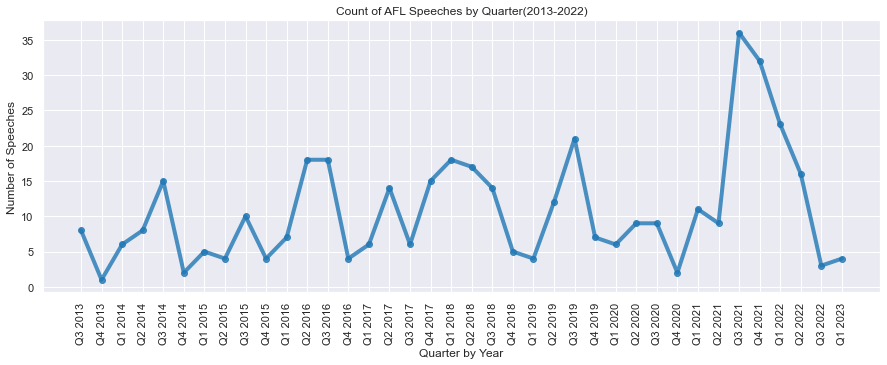

In [38]:
# define the chart configurations
chart_configs = {
    "chart_type": "line",  # line for plotting line chart, bar for bar chart
    
    "title": "Count of AFL Speeches by Quarter(2013-2022)",
    "x_label": "Quarter by Year",
    "y_label": "Number of Speeches",
    "color": "tab:blue",  # options: [tab:red, tab:green, tab:blue, tab:orange, tab:olive]
    "alpha": 0.8,  # change the value to 0 will make the chart transparent
    
    "markersize":6, # for line chart only
    "linewidth": 4, # for line chart only
    "marker": "o",  # for line chart only
    
    "font_size": 8  # big number for bigger font size
}

# usage
plot_chart(df_quarter, chart_configs)

# TOPIC MODELING

In [37]:
words = df['processed_clean_list']
words

0      [afl, cio, president, liz, shuler, delivered, ...
1      [afl, cio, secretary, treasurer, fred, redmond...
2      [afl, cio, secretary, treasurer, fred, redmond...
3      [afl, cio, president, liz, shulers, remarks, p...
4      [secretary, treasurer, fred, redmond, delivere...
                             ...                        
404    [wow, thank, thank, brothers, sisters, true, j...
405    [thank, brothers, sisters, confidence, want, t...
406    [thank, thank, together, solidarity, look, aro...
407    [thank, coming, together, los, angeles, thank,...
408    [thank, mike, great, brother, thank, inviting,...
Name: processed_clean_list, Length: 409, dtype: object

In [38]:
# Converting string to list
#res = ast.literal_eval(ini_list)
import ast
def res(string_list):
    return ast.literal_eval(string_list)
    

In [39]:
import gensim
from gensim import corpora
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# define the list of words to use for topic modeling
word_list = allwords

# create a list of documents, where each document is the word list
documents = [word_list]

In [47]:
words

/Users/jeffreypan/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0      [afl, cio, president, liz, shuler, delivered, ...
1      [afl, cio, secretary, treasurer, fred, redmond...
2      [afl, cio, secretary, treasurer, fred, redmond...
3      [afl, cio, president, liz, shulers, remarks, p...
4      [secretary, treasurer, fred, redmond, delivere...
                             ...                        
404    [wow, thank, thank, brothers, sisters, true, j...
405    [thank, brothers, sisters, confidence, want, t...
406    [thank, thank, together, solidarity, look, aro...
407    [thank, coming, together, los, angeles, thank,...
408    [thank, mike, great, brother, thank, inviting,...
Name: processed_clean_list, Length: 409, dtype: object

In [40]:
dictionary = corpora.Dictionary(words)
corpus = [dictionary.doc2bow(word) for word in words]

# define the number of topics to identify
num_topics = 4


# build the LDA model
lda_model = gensim.models.LdaModel(corpus=corpus,
                                   id2word=dictionary,
                                   num_topics=num_topics,
                                   random_state=100,
                                   update_every=1,
                                   chunksize=10,
                                   passes=10,
                                   alpha='auto',
                                   per_word_topics=True)

# visualize the topics using pyLDAvis
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

# print the top words for each topic
for topic in lda_model.print_topics():
    print(topic)

/Users/jeffreypan/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/jeffreypan/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


(0, '0.019*"trade" + 0.012*"workers" + 0.011*"economic" + 0.010*"global" + 0.010*"world" + 0.008*"economy" + 0.008*"people" + 0.006*"states" + 0.006*"policy" + 0.006*"wages"')
(1, '0.014*"us" + 0.012*"rights" + 0.010*"movement" + 0.010*"labor" + 0.008*"people" + 0.007*"today" + 0.007*"cio" + 0.007*"afl" + 0.007*"one" + 0.006*"justice"')
(2, '0.016*"re" + 0.014*"america" + 0.014*"working" + 0.013*"people" + 0.012*"us" + 0.012*"together" + 0.012*"work" + 0.012*"t" + 0.011*"ll" + 0.009*"want"')
(3, '0.016*"women" + 0.012*"work" + 0.010*"labor" + 0.009*"jobs" + 0.008*"climate" + 0.008*"change" + 0.008*"workers" + 0.008*"future" + 0.007*"energy" + 0.006*"movement"')


In [48]:
pyLDAvis.display(vis_data)

/Users/jeffreypan/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
